# MNIST 데이터 세트
- 머신러닝을 위한 이미지 데이터세트의 예제

In [4]:
import tensorflow as tf

mnist = tf.keras.datasets.mnist
# 수정의 노트설정을 gpu로 변경

In [5]:
(X_train, y_train),(X_test,y_test) = mnist.load_data()

X_train.shape, y_train.shape

11490434/11490434 [==============================] - 0s 0us/step


((60000, 28, 28), (60000,))

In [6]:
# TF : (N, H, W, C)
    # 개수, 세로크기(height), 가로길이(width), 채널(1:흑백[grayscale,기본값], 3: 컬러[RGB color])


# 시각화

In [7]:
# 첫번째 이미지 가져오기
image = X_train[0]

print(image.shape)

(28, 28)


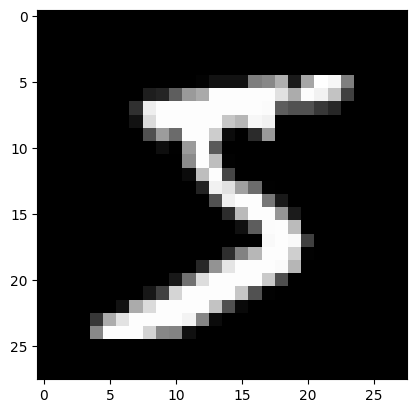

In [8]:
import matplotlib.pyplot as plt

plt.imshow(image, cmap='gray')
plt.show()
# 이미지는 숫자로 이뤄짐.검은색은 0

In [ ]:
# 이미지의 행렬 정보를 반드시 벡터로 바꾼다. 모든 정보를 포함하기 위해(Fully Connected Layer)
# (60000,28,28) -> (60000,784)
# (B, M)

# Fully Connected Layer 만들기
- 레이어들은 `tf.keras.layers` 패키지에 모두 들어 있다.
- `Flatten Layer` : 배치(BATCH)를 제외한 평탄화 담당 # (N, H, W, C) -> (N, ~), cpu보다 gpu가 빠름
  - `numpy` 할 때는 `reshape`, 배치 개수 따로 빼고 해야 했는데, 여기선 그럴 필요가 없다.
- ★★`Dense Layer` : `Affine`연산(신경망의 행렬 내적 계산). Fully Connected
  - `Dense Layer` 파라미터에 `activation`을 지정 가능
- `Activation Layer` : 활성화 함수 레이어(선택에 따라서 사용을 안할 수도 있다.)

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Activation

# Seauential 모델을 만들 때는 리스트에 레이어를 쌓아놓기만 하면된다.
model = Sequential([
    Input(shape=(28,28)), # 배치크기(N)를 제외한 나머지 데이터의 shape 입력
    Flatten(), # 평탄화 층. 배치사이즈를 제외한 나머지 차원을 평탄화

    # Fully Connected 구성

    #### Hidden layer####
    Dense(512, activation="relu"),
    Dense(256, activation="relu"),
    Dense(128, activation="relu"),
    Dense(64, activation="relu"),
    #######################

    # 출력층. 숫자는 0 ~ 9 까지 100개이므로 출력층의 뉴런의 개수는 10개, ACTIVATION FUNCTION은 SOFTMAX 
     Dense(10, activation='softmax')
])
   
# 모델 요약
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_5 (Dense)             (None, 512)               401920    
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                                 
 dense_7 (Dense)             (None, 128)               32896     
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                                 
 dense_9 (Dense)             (None, 10)                650       
                                                                 
Total params: 575,050
Trainable params: 575,050
Non-tr

# 최적화 계획 세우기 - 컴파일
* `Loss Function`(손실 함수) - MSE, CEE를 쓸지를 결정
* `Optimization`(최적화 함수) - SGD, ADAM, RMSProps 등을 지정
  * 거의 대부분 ADAM, RMSProps 등을 기본으로 사용
* `Metrics` - 테스트 세트에 대한 평가 기준
  * `acc`, `recall`, `precision`

## Loss Function 선정 기준
* 이진 분류를 수행하는 경우(Binary Classification)
  * `mse` : 출력층의 뉴런이 1개인 경우 - with `sigmoid`
  * `cross entropy error` : 출력층의 뉴런이 2개인 경우 - with `softmax` ( 제일 자주 사용되는 방법 )
    * **`binary_crossentropy`**를 사용하면 된다.
* 다중 분류를 수행하는 경우(Multiclass Classification)
  * `cross entropy error` : 출력층의 뉴런을 클래스의 개수만큼 설정
    * **`categorical_crossentropy`**를 사용하면 된다.

### Categorical Cross Entropy의 종류
  * Label이 `[0, 1, 2]` 처럼 One-Hot Encoding이 되어있지 않은 경우
    * **`sparse_categorical_crossentropy`**를 사용
  * Label이 One-Hot Encoding이 되어있는 경우
    * **`categorical_crossentropy`**를 사용

### y_train을 확인해서 어떤 LossFunction을 사용할지 결정

In [14]:
y_train.shape

(60000,)

In [15]:
y_train[:3]

array([5, 0, 4], dtype=uint8)

y_train 확인한 결과 OHE 되어있지 않은 상태. `sparse_categorical_crossentropy`를 활용하거나, y_train을 One Hot Encoding 한 다음 `categorical_crossentropy`를 사용하면 된다.

In [16]:
# loss function
loss_func = tf.keras.losses.sparse_categorical_crossentropy
loss_func

<function keras.losses.sparse_categorical_crossentropy(y_true, y_pred, from_logits=False, axis=-1, ignore_class=None)>

In [17]:
# y_train이 OHE이 되어 있으면 catrgorical_crossentropy
# 일반적으로 크롤링할 때는 레이블 인코딩이 나을 것
tf.keras.losses.categorical_crossentropy

<function keras.losses.categorical_crossentropy(y_true, y_pred, from_logits=False, label_smoothing=0.0, axis=-1)>

In [18]:
# 이진분류라면?
tf.keras.losses.binary_crossentropy

<function keras.losses.binary_crossentropy(y_true, y_pred, from_logits=False, label_smoothing=0.0, axis=-1)>

# Optimizer 설정
- `sgd` - `tf.keras.optimizers.SGD()`
- `rmsprops` - `tf.keras.optimizers.RMSprop()`
- `adam` - `tf.keras.optimizers.Adam()` - 일반적으로 제일 많이 사용하는 최적화 기법, 뭘 쓸지 모르겠다면 adam을 선택하세요a

In [21]:
optm = tf.keras.optimizers.Adam()
optm

# Metrics 설정
- 테스트(검증) 세트 평가 방법
- 훈련에 영향을 미치는 것이 아닌, 확인 용도의 설정
- 일반적으로는 정확도로 설정
  - 'accuracy', 'acc' 중 하나로 설정. 

In [19]:
metrics = ['acc']

In [22]:
# 훈련 수행 전에 모델에 손실함수, 최적화방법, 평가방법을 적용
model.compile(
    optimizer= optm,
    loss = loss_func,
    metrics = metrics
)

# 훈련

In [24]:
# 훈련용 하이퍼 파라미터 설정
# 에폭, 배치크기
num_epochs = 10
batch_size = 32

model.fit(
    X_train, # 훈련 X 데이터(feature)
    y_train, # 훈련 y 레이블(target)
    batch_size = batch_size,
    epochs = num_epochs,
    shuffle=True, # 데이터를 섞어 가면서 복잡하게 훈련 
    validation_split=0.2 # 전체 훈련데이터 중 검증 세트로 사용할 크기의 비율

) 

Epoch 1/10
1500/1500 [==============================] - 20s 11ms/step - loss: 0.7601 - acc: 0.8912 - val_loss: 0.2562 - val_acc: 0.9331
Epoch 2/10
1500/1500 [==============================] - 15s 10ms/step - loss: 0.1854 - acc: 0.9480 - val_loss: 0.1604 - val_acc: 0.9540
Epoch 3/10
1500/1500 [==============================] - 15s 10ms/step - loss: 0.1525 - acc: 0.9560 - val_loss: 0.1519 - val_acc: 0.9587
Epoch 4/10
1500/1500 [==============================] - 15s 10ms/step - loss: 0.1271 - acc: 0.9640 - val_loss: 0.1729 - val_acc: 0.9591
Epoch 5/10
1500/1500 [==============================] - 16s 11ms/step - loss: 0.1179 - acc: 0.9685 - val_loss: 0.1581 - val_acc: 0.9609
Epoch 6/10
1500/1500 [==============================] - 15s 10ms/step - loss: 0.0976 - acc: 0.9734 - val_loss: 0.1463 - val_acc: 0.9615
Epoch 7/10
1500/1500 [==============================] - 15s 10ms/step - loss: 0.0867 - acc: 0.9767 - val_loss: 0.1371 - val_acc: 0.9646
Epoch 8/10
1500/1500 [==========================

# 최종평가
- Test 세트로 평가

In [25]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 2s 5ms/step - loss: 0.1590 - acc: 0.9681


[0.15903855860233307, 0.9681000113487244]